In [45]:
import regex as re
import pandas as pd
import random
import requests
import urllib.request
from IPython.display import Image
#api de google sheets
from __future__ import print_function
import os.path
from bs4 import BeautifulSoup
import lxml.html
try:
    from googleapiclient.discovery import build
    from google_auth_oauthlib.flow import InstalledAppFlow
    from google.auth.transport.requests import Request
    from google.oauth2.credentials import Credentials
except:
    import sys
    !{sys.executable} -m pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
    from googleapiclient.discovery import build
    from google_auth_oauthlib.flow import InstalledAppFlow
    from google.auth.transport.requests import Request
    from google.oauth2.credentials import Credentials
try:
    from image import DrawImage
except:
    import sys
    !{sys.executable} -m pip install terminal-img
    from image import DrawImage

In [11]:
class Recomanador:
    
    def __init__(self):
        self.players = None
        self.dificultat = None
        self.dif_min = None
        self.dif_max = None
        self.temps = None
        
        
    
    def simple_questions(self):
        '''pregunta als jugadors: quants son, quina dificultat i quant de temps volen jugar'''
        while True:
            valid = False
            while valid == False:
                self.players = input('quants jugadors sou? ')
                if self.players.isnumeric():
                    self.players = int(self.players)
                    valid = True
            break

        while True:
            valid = False
            while valid == False:
                print('quina profunditat de joc esperes? Facil/Mitja/Dificil \n')
                self.dificultat = input('introdueix F,M o D ')
                if self.dificultat.upper() == 'F':
                    self.dificultat = self.dificultat.upper()
                    valid = True
                elif self.dificultat.upper() == 'M':
                    self.dificultat = self.dificultat.upper()
                    valid = True
                elif self.dificultat.upper() == 'D':
                    self.dificultat = self.dificultat.upper()
                    valid = True
            break

        if self.dificultat == 'F':
            self.dif_min = 0
            self.dif_max = 2.5
        elif self.dificultat == 'M':
            self.dif_min = 2
            self.dif_max = 3.5
        else:
            self.dif_min = 3.5
            self.dif_max = 5    

        while True:
            valid = False
            while valid == False:
                print('quanta estona voleu jugar aproximadament? ')
                self.temps = input('introdueix temps en minuts ')
                if self.temps.isnumeric():
                    self.temps = int(self.temps)
                    valid = True
            break
    
    
    def simple_choice(self,data):
        '''selecciona un joc, mostra una imatge si pot, i pregunta si va bé el joc seleccionat'''
        queried_jocs = data.query('min <= @self.players & max >= @self.players & Duració <= (@self.temps + 15) & Duració >= (@self.temps - 15) & Profunditat >= @self.dif_min & Profunditat <= @self.dif_max ')
        while True:
            
            # seleccionar juego al azar según criterios
            try:
                pick = random.choice(list(queried_jocs['Nom del joc']))
            except:
                print('no hi ha cap joc que cumpleixi els teus requisits\n')
                print("et recomanaré un joc a l'atzar\n")
                pick = random.choice(data['Nom del joc'])
            print(f' Perquè no jugueu a {pick} ?')
            
            # scrapeo de la imagen del juego
            try:
                # scrapeo de html para obtener la id del juego
                image = requests.get(f'https://www.boardgamegeek.com/search/boardgame?q={pick}&nosession=1&showcount=20', headers = {'user-agent': '{Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36}'})
                object_pattern = re.compile('/boardgame/([0-9]*)/')
                object_id = object_pattern.findall(image.text)[0]
                
                # scrapeo de api interna a partir de la id del juego
                resp = requests.get(f'https://api.geekdo.com/api/images?ajax=1&gallery=all&nosession=1&objectid={object_id}&objecttype=thing&pageid=1&showcount=36&size=thumb&sort=hot')
                # de las Imagenes recuperados seleccionamos una al azar de las 10 primeras
                image_url = resp.json()['images'][random.randint(0,10)]['imageurl_lg']
            except:
                print("No s'ha pogut trobar cap imatge del joc\n")
                image_url = None
            if image_url != None:
                # mostrar imagen en jupyter
                try:
                    display(Image(image_url))
                except:
                    print('No es pot mostrar la imatge')
            

            agree = input("T'agrada aquesta opció? Y/N ")
            if agree.upper() == 'Y':
                break

In [12]:
class JocDB:
    
    def __init__(self):
        self.jocs_list = []
        self.jocs_df = None
        
    
    def apiCall(self):
        '''usa la api de google sheets per recuperar la informació de la meva colecció'''
        # obtenim la jocs de taula sheet desded l'Api de google

        # If modifying these scopes, delete the file token.json.
        SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

        # The ID and range of a sample spreadsheet.
        SAMPLE_SPREADSHEET_ID = '1Ixtc7aIaMxe8XeKQC9fAfBerZxYFsifS0sy0X2yJfB4'
        SAMPLE_RANGE_NAME = 'Jocs - Gerard and Cris!A1:O222'

        creds = None
            # The file token.json stores the user's access and refresh tokens, and is
            # created automatically when the authorization flow completes for the first
            # time.
        if os.path.exists('token.json'):
            creds = Credentials.from_authorized_user_file('token.json', SCOPES)
        # If there are no (valid) credentials available, let the user log in.
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                flow = InstalledAppFlow.from_client_secrets_file(
                    'credentials.json', SCOPES)
                creds = flow.run_local_server(port=0)
            # Save the credentials for the next run
            with open('token.json', 'w') as token:
                token.write(creds.to_json())
        service = build('sheets', 'v4', credentials=creds)

        # Call the Sheets API
        print('retrieving boardgame collection from google sheets...')
        sheet = service.spreadsheets()
        result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                    range=SAMPLE_RANGE_NAME
                                   ).execute()
        values = result.get('values', [])
        self.jocs_list = values
        
    def toDf(self):
        '''transforma la informació obtinguda en un dataframe'''
        # creem a mà un Dataframe accedint a les llistes com si fosin columnes
        self.jocs_df = pd.DataFrame({'Nom del joc':[self.jocs_list[i][1] for i in range(3,len(self.jocs_list))],
                                     'Num. Jugadors':[self.jocs_list[i][2] for i in range(3,len(self.jocs_list))],
                                      'Gènere':[self.jocs_list[i][3] for i in range(3,len(self.jocs_list))],
                                      'Millor a 2?':[self.jocs_list[i][4] for i in range(3,len(self.jocs_list))],
                                      "Dificultat d'aprenentatge (sobre 5)":[self.jocs_list[i][5] for i in range(3,len(self.jocs_list))],
                                      'Profunditat':[float(self.jocs_list[i][6]) for i in range(3,len(self.jocs_list))],
                                      'Duració':[int(self.jocs_list[i][8]) for i in range(3,len(self.jocs_list))]
                                     })
        
        # continuem tractant el df
        minjoc = re.compile('([1-9]) a [1-9]')
        maxjoc = re.compile('[1-9] a ([1-9])')
        
        # creem noves columnes amb el min i el max
        for i in self.jocs_df['Num. Jugadors'].index:
            min_p = minjoc.findall(self.jocs_df.loc[i,'Num. Jugadors'])
            if len(min_p) > 0:
                min_p = int(min_p[0])
                self.jocs_df.loc[i,'min'] = min_p
            else:
                self.jocs_df.loc[i,'min'] = 0
            max_p = maxjoc.findall(self.jocs_df.loc[i,'Num. Jugadors'])
            if len(max_p) > 0:
                max_p = int(max_p[0])
                self.jocs_df.loc[i,'max'] = max_p
            else:
                self.jocs_df.loc[i,'max'] = 0
            
        #jocs només per un numero fix de persones
        for i in self.jocs_df['Num. Jugadors'].index:
            if self.jocs_df.loc[i,'min'] == 0:
                self.jocs_df.loc[i,'min'] = int(self.jocs_df.loc[i,'Num. Jugadors'])
                self.jocs_df.loc[i,'max'] = int(self.jocs_df.loc[i,'Num. Jugadors'])
       


In [13]:
def main():
    # creem la conexió
    coleccio = JocDB()
    try:
        coleccio.apiCall()
    except:
        raise 'Conexió amb API ha fallat'
    
    # transformem a DataFrame
    coleccio.toDf()
    game_df = coleccio.jocs_df
    
    # creem el recomanador
    recom = Recomanador()
    recom.simple_questions()
    recom.simple_choice(game_df)

retrieving boardgame collection from google sheets...
quants jugadors sou? 4
quina profunditat de joc esperes? Facil/Mitja/Dificil 

introdueix F,M o D m
quanta estona voleu jugar aproximadament? 
introdueix temps en minuts 60
 Perquè no jugueu a La isla del botín ?


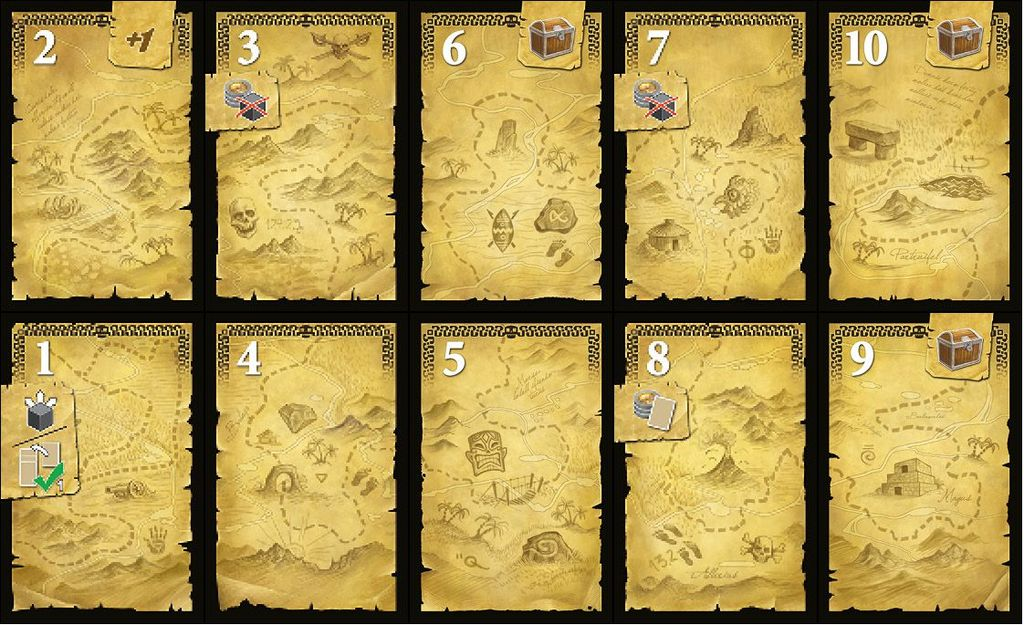

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a Pan Am ?


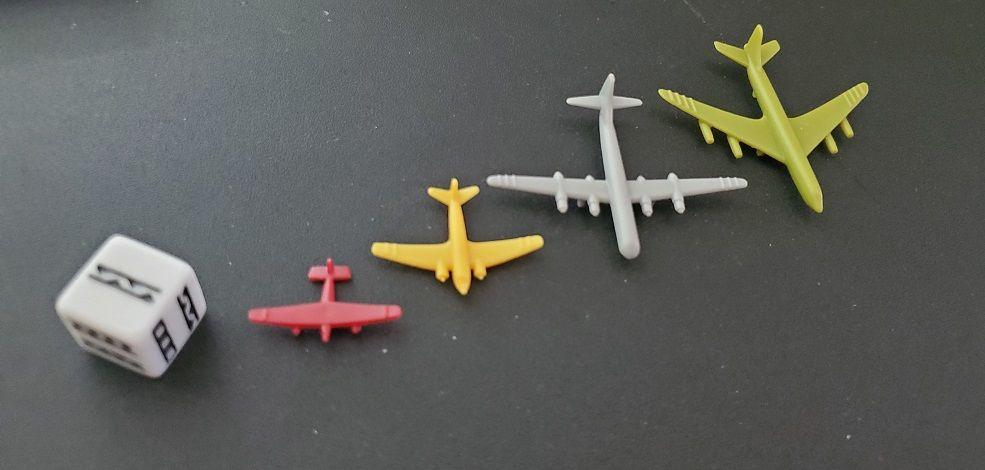

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a Inkognito ?


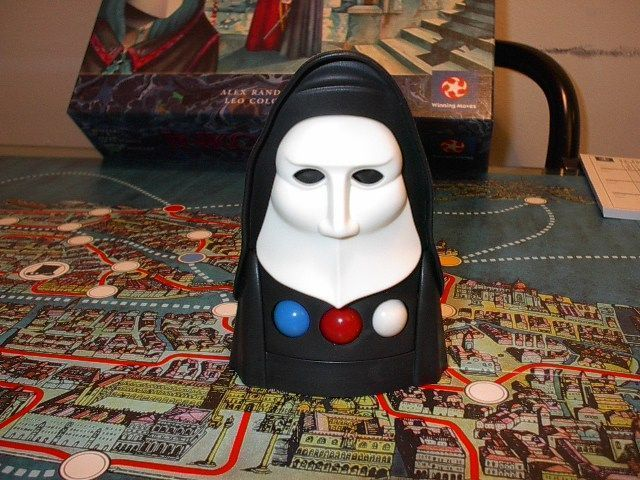

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a La isla del botín ?


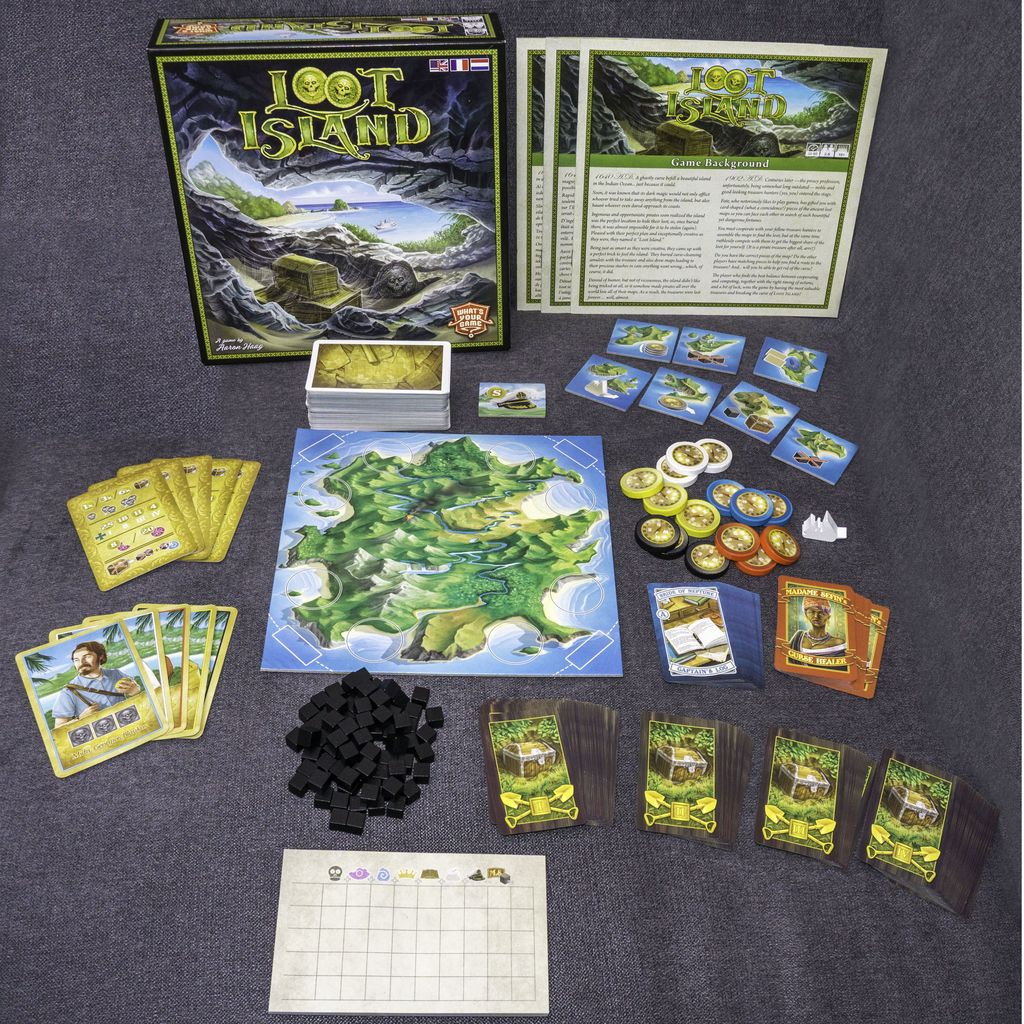

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a Carcassonne ?


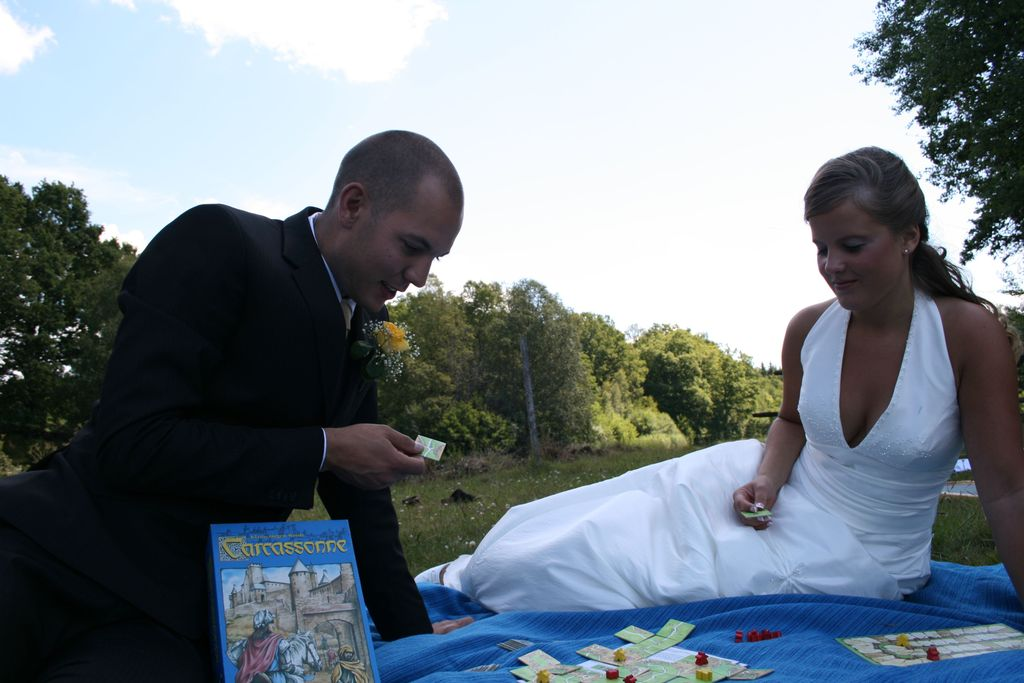

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a Dragon castle ?


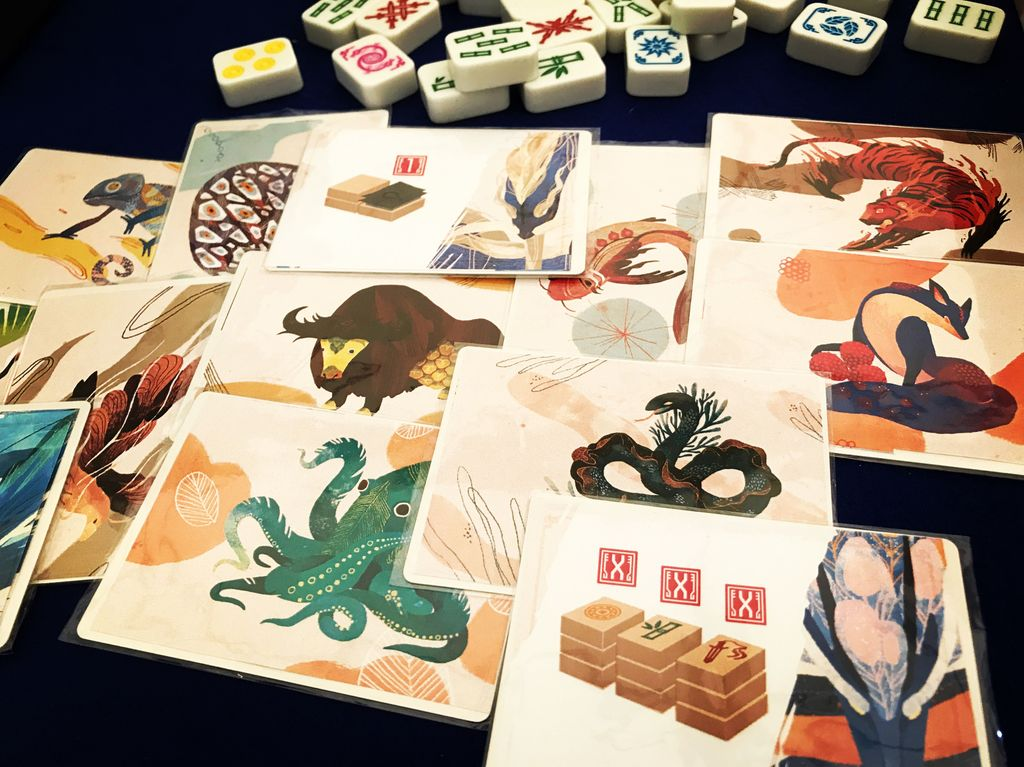

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a Wingspan ?


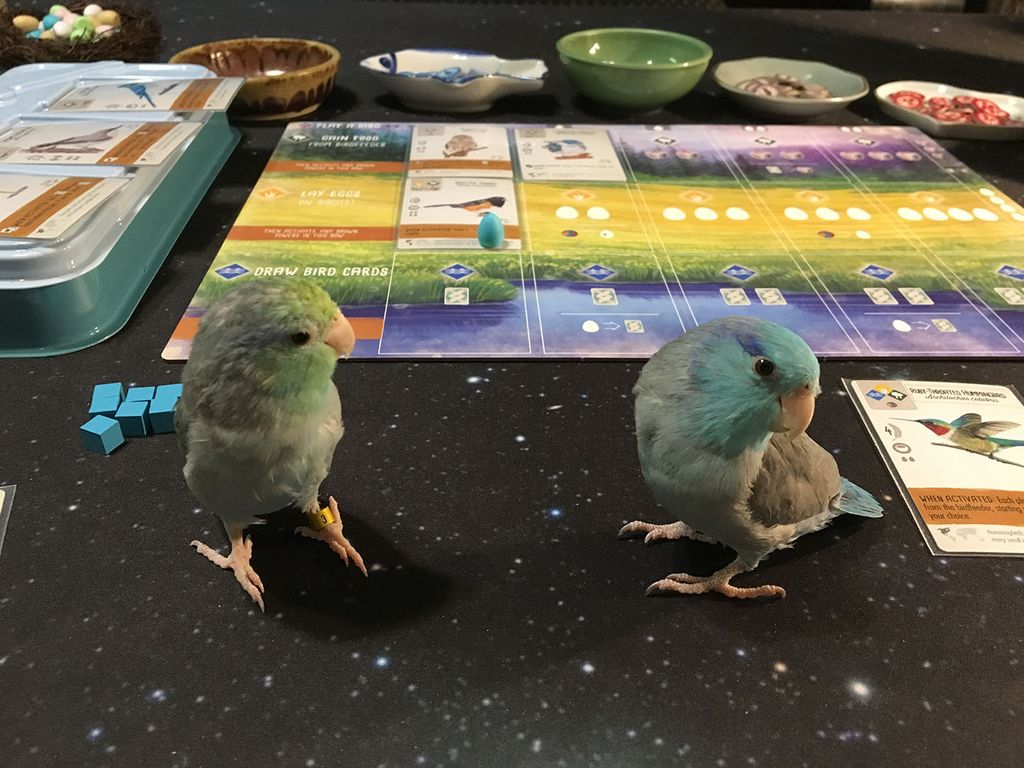

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a Pan Am ?


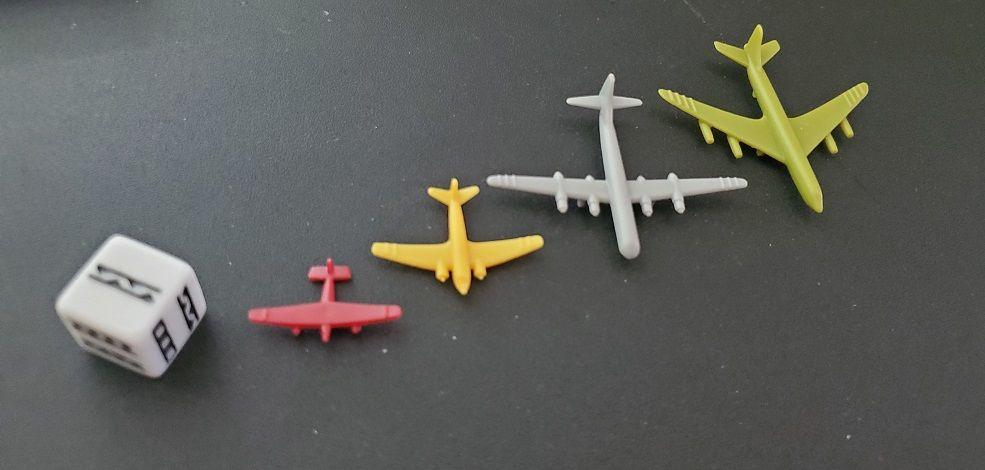

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a Shinkansen: Zero - kei ?


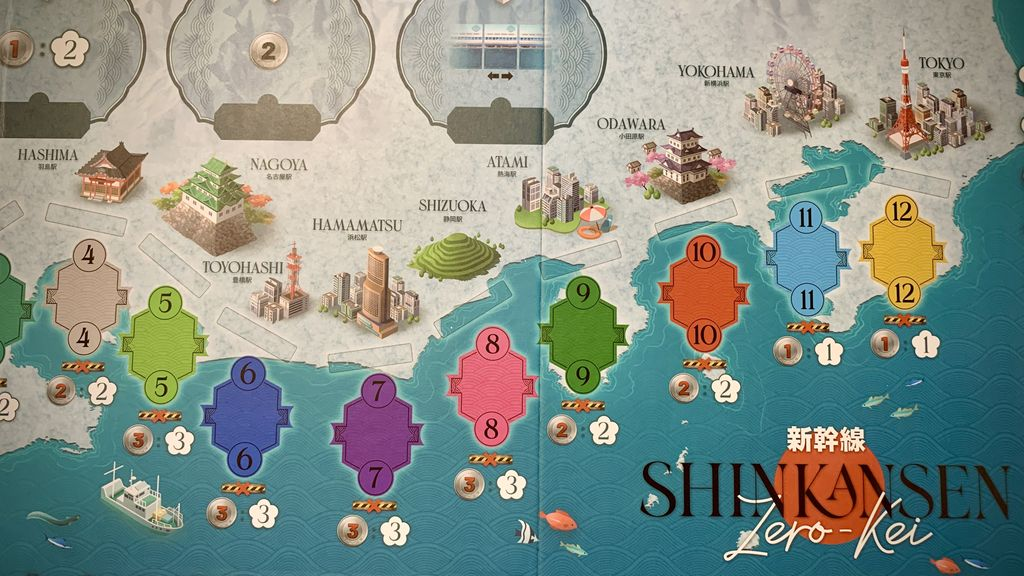

T'agrada aquesta opció? Y/N y


In [14]:
main()

In [74]:
resp = requests.get('https://www.boardgamegeek.com/boardgame/339614/', headers = {'user-agent': '{Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36}'})

In [75]:
bs_obj = BeautifulSoup(resp.content,'html.parser')

In [94]:
for i in bs_obj.find('body').find('div',attrs={'class':'d-flex'}).find('main',attrs={'class':'global-body'}).find('div',attrs={'class':'global-body-content-container'}).find('div',attrs={'class':'global-body-content'}):
    print(i)



<a id="maincontenttarget" tabindex="-1"></a>


<script src="https://cdnjs.cloudflare.com/ajax/libs/highcharts/8.2.2/highstock.src.min.js"></script>


<script src="https://cdnjs.cloudflare.com/ajax/libs/highcharts/8.2.2/modules/accessibility.min.js"></script>


<script src="https://cdnjs.cloudflare.com/ajax/libs/highcharts/8.2.2/themes/sand-signika.min.js"></script>


<geekitem linkshowcount="6" subtype="boardgame"></geekitem>


 Matomo 


<script>
	var _paq = window._paq = window._paq || [];
	/* tracker methods like "setCustomDimension" should be called before "trackPageView" */
	_paq.push(['enableLinkTracking']);
	(function() {
		var u="//analytics.geekdo.com/";
		_paq.push(['setTrackerUrl', u+'matomo.php']);
		_paq.push(['setSiteId', '1']);
		var d=document, g=d.createElement('script'), s=d.getElementsByTagName('script')[0];
		g.async=true; g.src=u+'matomo.js'; s.parentNode.insertBefore(g,s);
	})();
</script>


 End Matomo Code 


<div class="global-body-content-secondary">
</div>


In [ ]:
/html/body/div[2]/main/div/div[1]/div[1]/div[2]/ng-include/div/div/ui-view/ui-view/div/overview-module/marketplace-module

In [34]:
bs_obj.find('html').find('body').find_all('div')[2].find('main')

In [71]:
root = lxml.html.fromstring()

TypeError: expected string or bytes-like object

In [68]:
root.xpath('/html/body/div[2]/main/div/div[1]/div[1]/div[2]/ng-include/div/div/ui-view/ui-view/div/overview-module/marketplace-module')

[]

In [72]:
bs_obj.contents

['html',
 '\n',
 <html lang="en-US" ng-app="GeekApp" ng-cloak="">
 <head>
 <meta charset="utf-8"/>
 <meta content="width=device-width, initial-scale=1.0" id="vp" name="viewport"/>
 <meta content="yes" name="apple-mobile-web-app-capable"/>
 <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
 <title>Shinkansen: Zero Kei | Board Game | BoardGameGeek</title>
 <link href="https://boardgamegeek.com/boardgame/339614/shinkansen-zero-kei" rel="canonical"/>
 <link href="https://cf.geekdo-static.com/icons/touch-icon180.png" rel="apple-touch-icon"/>
 <link href="https://cf.geekdo-static.com/icons/favicon2.ico" rel="shortcut icon" type="image/ico"/>
 <link href="https://cf.geekdo-static.com/icons/favicon2.ico" rel="icon" type="image/ico"/>
 <link href="/game-opensearch.xml" rel="search" title="BGG Game Search" type="application/opensearchdescription+xml"/>
 <meta content="BGG" name="apple-mobile-web-app-title"/>
 <meta content="#2e2b47" name="theme-color"/>
 <link href="https://www.goo